In [4]:
# ! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! pip install --upgrade --force-reinstall --no-deps kaggle
! kaggle competitions download -c house-prices-advanced-regression-techniques
! unzip /content/house-prices-advanced-regression-techniques.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 10.7MB/s]
Archive:  /content/house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [8]:
train = pd.read_csv("../content/train.csv")
test = pd.read_csv("../content/test.csv")

In [10]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b69198a10>,
      dtype=object)

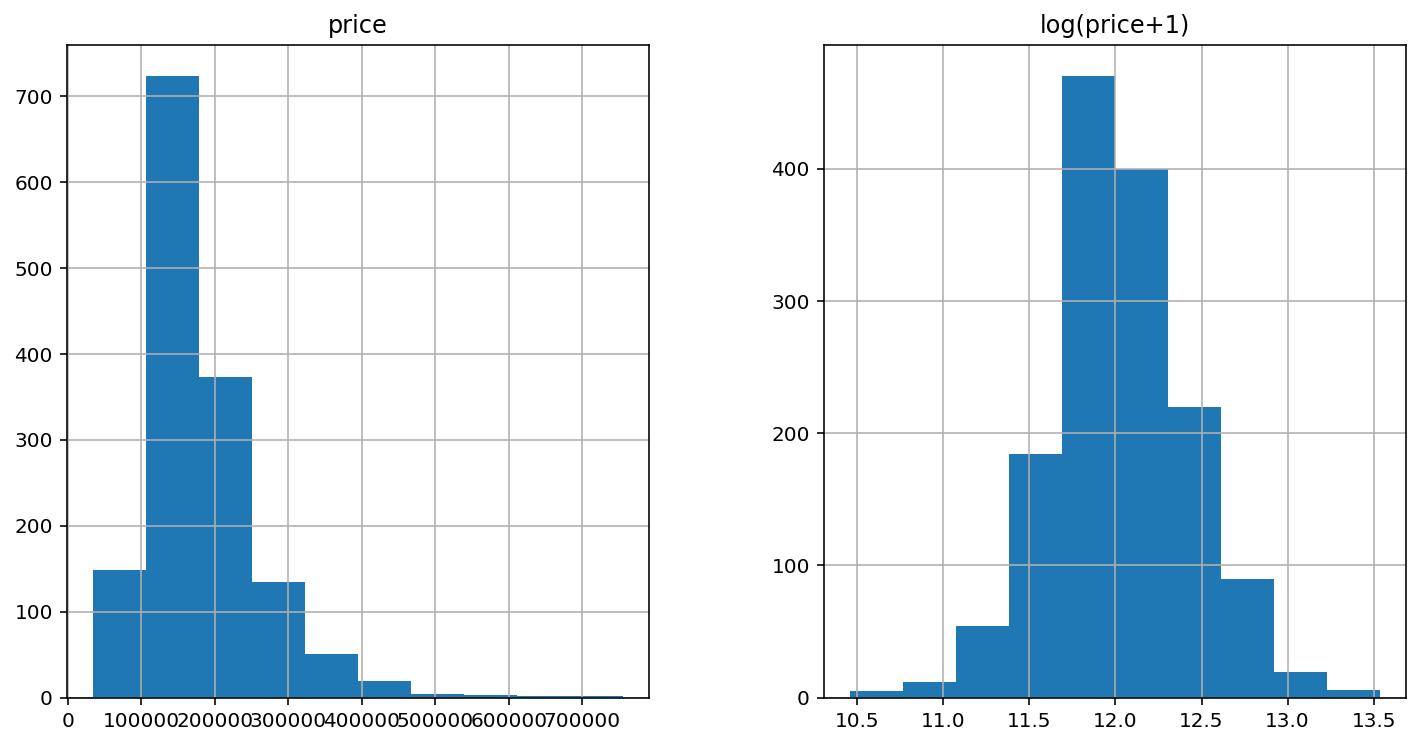

In [12]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

prices = pd.DataFrame({"price":train['SalePrice'], "log(price+1)":np.log1p(train['SalePrice']) })
prices.hist()

In [ ]:
# Log Transfom Y variable
train["SalePrice"] = np.log1p(train['SalePrice'])

# Log tranform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed 